## **Preprocessing Dataset features with Davis Bouldin Index and Calculation was implemented with cluster report**


In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

class CustomerSegmentation:
    def __init__(self):
        self.scaler = StandardScaler()
        self.best_model = None
        self.feature_matrix = None
        self.n_clusters = None
        
    def preprocess_features(self, customers_df, transactions_df):
  

        customer_features = pd.get_dummies(customers_df, columns=['Region'])
        customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])
        customer_features['DaysSinceSignup'] = (
            pd.Timestamp('2024-01-01') - customer_features['SignupDate']
        ).dt.days
        

        transaction_features = transactions_df.groupby('CustomerID').agg({
            'TotalValue': ['sum', 'mean', 'count'],
            'Quantity': ['sum', 'mean'],
            'TransactionDate': ['min', 'max']
        }).fillna(0)
        
        transaction_features.columns = [
            'total_spend', 'avg_transaction', 'transaction_count',
            'total_items', 'avg_items',
            'first_purchase', 'last_purchase'
        ]

        transaction_features['recency'] = (
            pd.Timestamp('2024-01-01') - 
            pd.to_datetime(transaction_features['last_purchase'])
        ).dt.days
        
        transaction_features['frequency'] = transaction_features['transaction_count'] / \
            ((pd.to_datetime(transaction_features['last_purchase']) - 
              pd.to_datetime(transaction_features['first_purchase'])).dt.days + 1)
        

        combined_features = customer_features.join(
            transaction_features, on='CustomerID'
        ).fillna(0)
        

        numerical_features = combined_features.select_dtypes(include=[np.number])
        

        self.feature_matrix = self.scaler.fit_transform(numerical_features)
        return self.feature_matrix
    
    def davies_bouldin_index(self, X, labels):
 
        n_clusters = len(np.unique(labels))
        cluster_centers = np.array([X[labels == i].mean(axis=0) 
                                  for i in range(n_clusters)])
        

        dispersions = np.zeros(n_clusters)
        for i in range(n_clusters):
            if np.sum(labels == i) > 0: 
                cluster_points = X[labels == i]
                dispersions[i] = np.mean(
                    np.linalg.norm(cluster_points - cluster_centers[i], axis=1)
                )
        

        db_index = 0
        for i in range(n_clusters):
            max_ratio = 0
            for j in range(n_clusters):
                if i != j:
                    center_distance = np.linalg.norm(
                        cluster_centers[i] - cluster_centers[j]
                    )
                    if center_distance != 0:  # Avoid division by zero
                        ratio = (dispersions[i] + dispersions[j]) / center_distance
                        max_ratio = max(max_ratio, ratio)
            db_index += max_ratio
        
        return db_index / n_clusters
    
    def find_optimal_clusters(self, min_clusters=2, max_clusters=10):
  
        results = []
        
        for n_clusters in range(min_clusters, max_clusters + 1):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(self.feature_matrix)
            
            db_index = self.davies_bouldin_index(self.feature_matrix, labels)
            silhouette = silhouette_score(self.feature_matrix, labels)
            calinski = calinski_harabasz_score(self.feature_matrix, labels)
            
            results.append({
                'n_clusters': n_clusters,
                'db_index': db_index,
                'silhouette': silhouette,
                'calinski': calinski
            })
            
        results_df = pd.DataFrame(results)

        self.n_clusters = results_df.loc[
            results_df['db_index'].idxmin(), 'n_clusters'
        ]
        
  
        self.best_model = KMeans(
            n_clusters=self.n_clusters, random_state=42
        ).fit(self.feature_matrix)
        
        return results_df
    
    def visualize_clusters(self):


        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(self.feature_matrix)
        

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
  
        scatter = ax1.scatter(
            reduced_features[:, 0], 
            reduced_features[:, 1], 
            c=self.best_model.labels_,
            cmap='viridis'
        )
        ax1.set_title('Customer Segments (PCA)')
        ax1.set_xlabel('First Principal Component')
        ax1.set_ylabel('Second Principal Component')
        ax1.legend(*scatter.legend_elements(), title="Clusters")
        

        cluster_sizes = pd.Series(
            self.best_model.labels_
        ).value_counts().sort_index()
        cluster_sizes.plot(kind='bar', ax=ax2)
        ax2.set_title('Cluster Size Distribution')
        ax2.set_xlabel('Cluster')
        ax2.set_ylabel('Number of Customers')
        
        plt.tight_layout()
        return fig

    def generate_cluster_report(self):

        report = {
            'n_clusters': self.n_clusters,
            'db_index': self.davies_bouldin_index(
                self.feature_matrix, 
                self.best_model.labels_
            ),
            'silhouette_score': silhouette_score(
                self.feature_matrix, 
                self.best_model.labels_
            ),
            'calinski_score': calinski_harabasz_score(
                self.feature_matrix, 
                self.best_model.labels_
            ),
            'cluster_sizes': pd.Series(
                self.best_model.labels_
            ).value_counts().to_dict()
        }
        return report

# **Segmenting and creating cluster matrix with plotly visualisation**


<Figure size 1000x600 with 0 Axes>

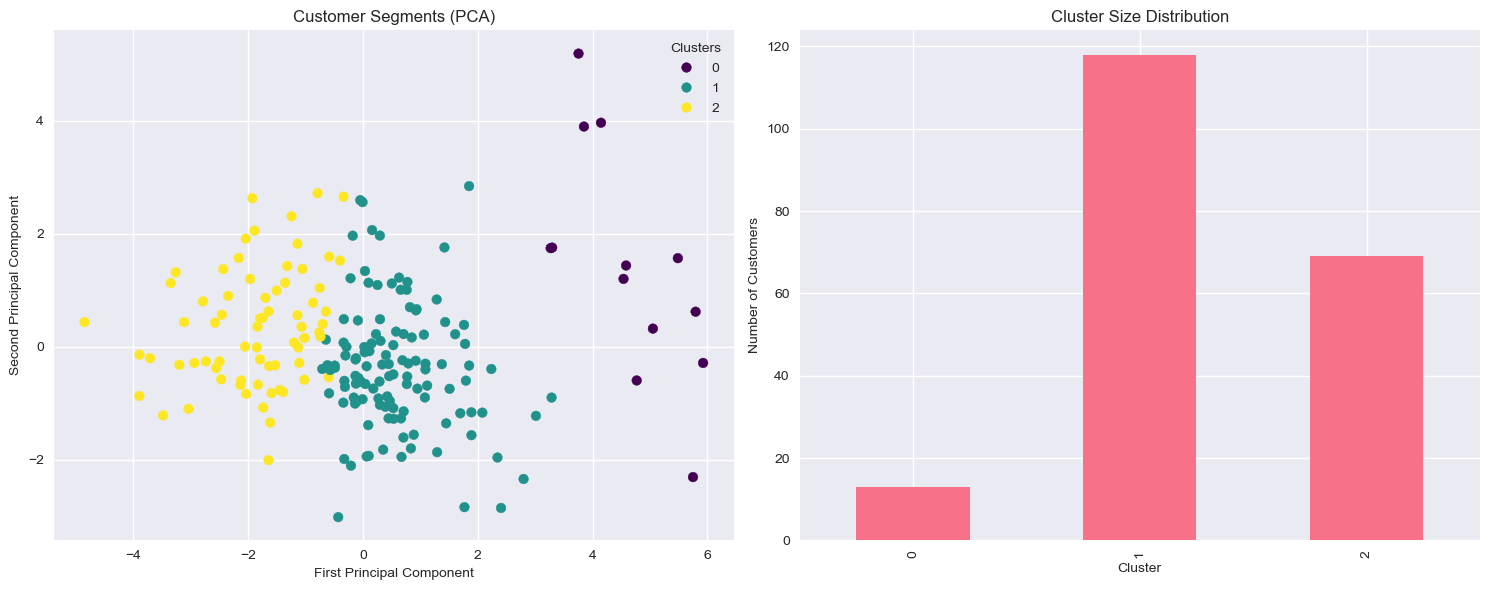


Clustering Report:
Number of clusters: 3
Davies-Bouldin Index: 1.2467
Silhouette Score: 0.2749
Calinski-Harabasz Score: 78.4733

Cluster sizes:
Cluster 1: 118 customers
Cluster 2: 69 customers
Cluster 0: 13 customers


In [43]:

segmentation = CustomerSegmentation()
feature_matrix = segmentation.preprocess_features(customers_df, transactions_df)


clustering_metrics = segmentation.find_optimal_clusters(min_clusters=2, max_clusters=10)


plt.figure(figsize=(10, 6))
fig = segmentation.visualize_clusters()
plt.show()   #Copyright to Vastav Bishnoi


report = segmentation.generate_cluster_report()
print("\nClustering Report:")
print(f"Number of clusters: {report['n_clusters']}")
print(f"Davies-Bouldin Index: {report['db_index']:.4f}")
print(f"Silhouette Score: {report['silhouette_score']:.4f}")
print(f"Calinski-Harabasz Score: {report['calinski_score']:.4f}")
print("\nCluster sizes:")
for cluster, size in report['cluster_sizes'].items():
    print(f"Cluster {cluster}: {size} customers")

# **3d - Customer Segmentation**

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


plt.style.use('seaborn')
sns.set_palette("husl")

class EcommerceVisualizer:
    def __init__(self, customers_df, products_df, transactions_df):
        """Initialize with the three main dataframes"""
        self.customers_df = customers_df.copy()
        self.products_df = products_df.copy()
        self.transactions_df = transactions_df.copy()
        self.prepare_data()

    def prepare_data(self):
        
        
        self.customers_df['SignupDate'] = pd.to_datetime(self.customers_df['SignupDate'])
        self.transactions_df['TransactionDate'] = pd.to_datetime(self.transactions_df['TransactionDate'])
        
        
        self.enriched_transactions = self.transactions_df.merge(
            self.customers_df[['CustomerID', 'Region', 'SignupDate']], 
            on='CustomerID'
        ).merge(
            self.products_df[['ProductID', 'Category']], 
            on='ProductID'
        )

    def plot_sales_trends(self):
        
        # Prepare daily sales data
        daily_sales = self.enriched_transactions.groupby(
            self.enriched_transactions['TransactionDate'].dt.date
        ).agg({
            'TotalValue': 'sum',
            'TransactionID': 'count',
            'CustomerID': 'nunique'
        }).reset_index()

        
        fig = make_subplots(
            rows=2, cols=1,
            subplot_titles=('Daily Sales Value', 'Daily Transaction Count'),
            vertical_spacing=0.12
        )

        
        fig.add_trace(
            go.Scatter(
                x=daily_sales['TransactionDate'],
                y=daily_sales['TotalValue'],
                mode='lines',
                name='Sales Value',
                line=dict(color='#1f77b4', width=2)
            ),
            row=1, col=1
        )

        
        fig.add_trace(
            go.Scatter(
                x=daily_sales['TransactionDate'],
                y=daily_sales['TransactionID'],
                mode='lines',
                name='Transaction Count',
                line=dict(color='#2ca02c', width=2)
            ),
            row=2, col=1
        )

        
        fig.update_layout(
            height=800,
            showlegend=True,
            title_text="Sales and Transaction Trends",
            title_x=0.5,
            template='plotly_white'
        )

        return fig   #Copyright to Vastav Bishnoi


    def plot_customer_segments(self):
        
        
        current_date = self.transactions_df['TransactionDate'].max()
        
        rfm = self.transactions_df.groupby('CustomerID').agg({
            'TransactionDate': lambda x: (current_date - x.max()).days,  # Recency
            'TransactionID': 'count',  # Frequency
            'TotalValue': 'sum'  # Monetary
        }).reset_index()
        
        
        rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

        
        fig = px.scatter_3d(
            rfm,
            x='Recency',
            y='Frequency',
            z='Monetary',
            color='Monetary',
            size='Frequency',
            opacity=0.7,
            color_continuous_scale='Viridis'
        )

        
        fig.update_layout(
            title='Customer Segmentation (RFM Analysis)',
            scene=dict(
                xaxis_title='Recency (days)',
                yaxis_title='Frequency (orders)',
                zaxis_title='Monetary (total spend)'
            ),
            template='plotly_white',
            height=800
        )

        return fig


/var/folders/jm/t_p6_mqs729_c9yg28w4k5hh0000gn/T/ipykernel_80312/4123954869.py:11: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [82]:
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

visualizer = EcommerceVisualizer(customers_df, products_df, transactions_df)

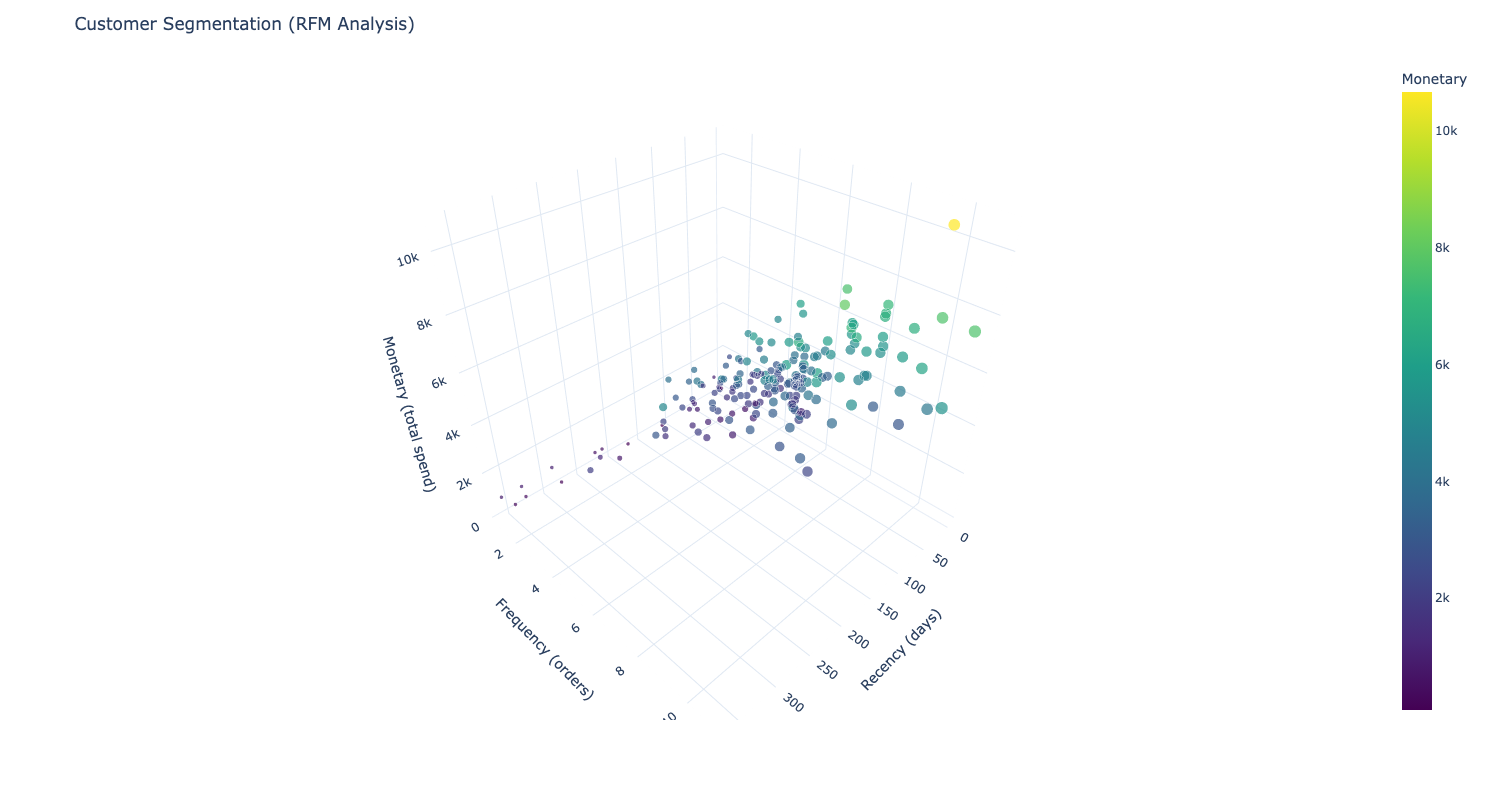

In [84]:
fig_segments = visualizer.plot_customer_segments()
fig_segments.show()

In [92]:
!pip install reportlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.6 MB/s eta 0:00:00 0:00:01


In [113]:
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
import io
import matplotlib.pyplot as plt

def save_cluster_report_pdf(self, filename="cluster_analysis_report.pdf"):
    
    doc = SimpleDocTemplate(filename, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Heading1'],
        fontSize=24,
        spaceAfter=30
    )
    story.append(Paragraph("Customer Segmentation Analysis Report -- Vastav Bishnoi", title_style))
    story.append(Spacer(1, 12))

    
    story.append(Paragraph("Clustering Statistics", styles['Heading2']))
    story.append(Spacer(1, 12))
    
    report_data = self.generate_cluster_report()
    
    
    stats_data = [
        ['Metric', 'Value'],
        ['Number of Clusters', str(report_data['n_clusters'])],
        ['Davies-Bouldin Index', f"{report_data['db_index']:.3f}"],
        ['Silhouette Score', f"{report_data['silhouette_score']:.3f}"],
        ['Calinski-Harabasz Score', f"{report_data['calinski_score']:.3f}"]
    ]
    
    stats_table = Table(stats_data, colWidths=[4*inch, 2*inch])
    stats_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 14),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 12),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))
    story.append(stats_table)
    story.append(Spacer(1, 20))

    
    story.append(Paragraph("Cluster Size Distribution", styles['Heading2']))
    story.append(Spacer(1, 12))
    
    cluster_sizes = [
        ['Cluster', 'Number of Customers']
    ]
    for cluster, size in report_data['cluster_sizes'].items():
        cluster_sizes.append([f"Cluster {cluster}", str(size)])
    
    size_table = Table(cluster_sizes, colWidths=[3*inch, 3*inch])
    size_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 14),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 12),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))
    story.append(size_table)
    story.append(Spacer(1, 20))#Copyright to Vastav Bishnoi

  
    story.append(Paragraph("Cluster Visualizations", styles['Heading2']))
    story.append(Spacer(1, 12))
    
  
    buf = io.BytesIO()
    fig = self.visualize_clusters()
    fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    buf.seek(0)
    
    img = Image(buf)
    img.drawHeight = 4*inch
    img.drawWidth = 7*inch
    story.append(img)
    
 
    doc.build(story)
    plt.close()


CustomerSegmentation.save_cluster_report_pdf = save_cluster_report_pdf

In [115]:

segmentation = CustomerSegmentation()
segmentation.preprocess_features(customers_df, transactions_df)
segmentation.find_optimal_clusters()


segmentation.save_cluster_report_pdf("Vastav_Bishnoi_Clustering.pdf")